In [112]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# split data in 60%/20%/20% train/validation/test sets
valid_set_size_percentage = 20 
test_set_size_percentage = 20 

from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

In [16]:
df = pd.read_csv('dataset/Iron ore fines 62% Fe CFR Futures Historical Data.csv')

In [18]:
df = df.drop(['Vol.', 'Change %'], axis=1)

In [22]:
s = 0
l = 714
for i in range(round(len(df)/2)):
    s_temp = df.iloc[s].copy()
    l_temp = df.iloc[l].copy()
    df.iloc[s] = l_temp
    df.iloc[l] = s_temp
    s = s + 1
    l = l -1

In [25]:
from dateutil import parser
for i in range(len(df['Date'])):
    dt = parser.parse(df['Date'][i])
    df['Date'][i] = dt.strftime("%Y-%m-%d")
    #print(train['Date'][i], i)
df = df.set_index('Date')

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [32]:
import plotly
plotly.tools.set_credentials_file(username='sumon23', api_key='zqTb8KrZdBd7cVBAUPk4')

In [53]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#plot(data)

price = go.Scatter(
                x=df.index,
                y=df['Price'],
                name = "Price",
                line = dict(color = 'red') 
               # opacity = 0.2
                )

open_price = go.Scatter(
                x=df.index,
                y=df['Open'],
                name = "Open",
                line = dict(color = 'green')
                #opacity = 0.8
                )
high_price = go.Scatter(
                x=df.index,
                y=df['High'],
                name = "High",
                line =  dict(color = 'blue')
                #opacity = 0.8
                )

low_price = go.Scatter(
                x=df.index,
                y=df['Low'],
                name = "Low",
                line =  dict(color = 'black')
                #opacity = 0.8
                )
data = [price,open_price,high_price,low_price]

layout = go.Layout(title='Iron Ore Price', xaxis=dict(title='Date'),
                   yaxis=dict(title='(Price)'))
#fig = go.Figure(data=[data], layout=layout)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Irn Ore Price")

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [60]:
# Significant coorelation between lags 
# acf = plot_acf(df['Open'], lags = 20)
# No significant pattern in pacf
# pacf = plot_pacf(df['Open'], lags = 20)

In [61]:
w = 20 # define window size

In [67]:
roll_df = df.rolling(window=w).mean() #20 row avg
roll_df.dropna(inplace=True)
roll_df.describe()

,Price,Open,High,Low
count,696.000000,696.000000,696.000000,696.000000
mean,65.418325,65.418325,65.879064,64.334416
std,10.073146,10.073146,10.101760,9.997210
min,40.857500,40.857500,41.293500,37.638500
25%,57.754875,57.754875,58.168625,56.543500
50%,65.429500,65.429500,65.783750,65.007750
75%,73.021375,73.021375,73.718750,71.622375
max,87.637000,87.637000,88.162500,86.695000


In [70]:
start = min(df.index.tolist())
end = max(df.index.tolist())
print("Start date: ", start, ", End date: ", end)
roll_df.head()

Start date:  2016-01-04 , End date:  2018-10-16


,Price,Open,High,Low
Date,,,,
2016-01-29,40.8575,40.8575,41.2935,37.6385
2016-02-02,40.9375,40.9375,41.3135,37.8760
2016-02-03,41.0400,41.0400,41.3635,37.8735
2016-02-04,41.2065,41.2065,41.5110,38.2535
2016-02-05,41.3615,41.3615,41.6810,38.7760


In [73]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    return df

In [74]:
# normalize stock
df_norm = df.copy()
df_norm = normalize_data(df_norm)
df_norm.head()

,Price,Open,High,Low
Date,,,,
2016-01-04,0.043804,0.043804,0.061815,0.081705
2016-01-05,0.040253,0.040253,0.054835,0.071936
2016-01-06,0.028414,0.028414,0.030907,0.049734
2016-01-07,0.029006,0.029006,0.019940,0.001776
2016-01-08,0.022494,0.022494,0.021934,0.000000


In [102]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array shape (715,4)
    print(data_raw.shape)
    data = []
    cnt = 0
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    
    data = np.array(data);
    print(data.shape)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:] #take the last row from every 20 steps
    #y_train = data[:,-1][:,-1]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
  
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [103]:
# create train, test data
seq_len = 19 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len+1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

(715, 4)
(695, 20, 4)
x_train.shape =  (417, 19, 4)
y_train.shape =  (417, 4)
x_valid.shape =  (139, 19, 4)
y_valid.shape =  (139, 4)
x_test.shape =  (139, 19, 4)
y_test.shape =  (139, 4)


C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [106]:
# Choose only  Prices column
x_train, y_train, x_valid, y_valid, x_test, y_test = x_train[:,:,0], y_train[:,0], x_valid[:,:,0], y_valid[:,0], x_test[:,:,0], y_test[:,0]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (417, 19)
y_train.shape =  (417,)
x_valid.shape =  (139, 19)
y_valid.shape =  (139,)
x_test.shape =  (139, 19)
y_test.shape =  (139,)


In [107]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_valid = x_valid.reshape((x_valid.shape[0],x_valid.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [113]:
#Build the model
#Predict every 20th time step
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, input_shape=(seq_len, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.021941423416137695


In [114]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 19, 256)           264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 797,761
Trainable params: 797,761
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.fit(x_train,y_train,epochs=2,validation_data=(x_valid,y_valid),verbose=1,shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 417 samples, validate on 139 samples
Epoch 1/2
417/417 [==============================] - 4s 9ms/step - loss: 0.1175 - acc: 0.0024 - val_loss: 0.0205 - val_acc: 0.0000e+00
Epoch 2/2
417/417 [==============================] - 1s 3ms/step - loss: 0.1337 - acc: 0.0000e+00 - val_loss: 0.0818 - val_acc: 0.0000e+00


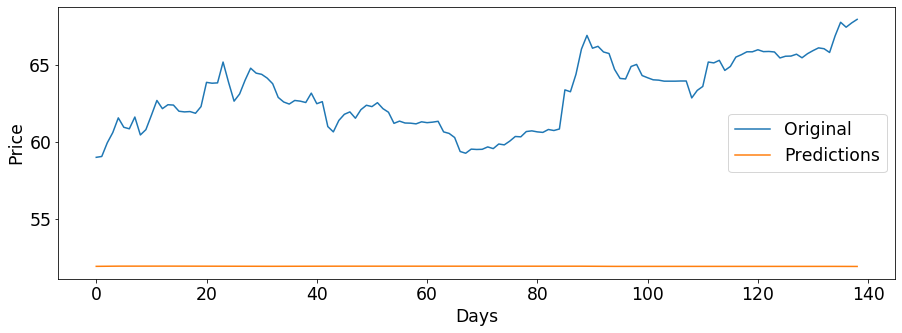

In [117]:
# Visualise predictions
pred_price = model.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot( np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(y_test.reshape(-1,1)),label='Original')
plt.plot(np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(pred_price), label ='Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [120]:
len(pred_price)

139

In [121]:
len(y_test)

139